In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score
from xgboost import plot_importance


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/pubg-finish-placement-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [64]:
train_df = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv")
test_df = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv")
sub = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [3]:
test_df = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv")

In [65]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df["winPlacePerc"] = imputer.fit_transform(train_df[["winPlacePerc"]])

In [66]:
train_df = train_df.drop(["killPoints","damageDealt", "rankPoints", "winPoints", "numGroups", "maxPlace", "roadKills", "teamKills", "vehicleDestroys" ,"groupId"], axis=1)

In [6]:
#train_df = train_df.drop(["groupId"], axis=1)

In [67]:
sample_train_df= train_df.sample(frac=0.05, random_state=42)

In [8]:
"""corr_mat=sample_train_df.corr(numeric_only = True)"""

'corr_mat=sample_train_df.corr(numeric_only = True)'

In [9]:
"""plt.figure(figsize=(30, 16))  
sns.heatmap(corr_mat1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()"""

'plt.figure(figsize=(30, 16))  \nsns.heatmap(corr_mat1, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=.5)\nplt.title(\'Correlation Matrix Heatmap\')\nplt.show()'

In [10]:
"""sns.scatterplot(x='boosts', y='matchDuration', data=sample_train_df, hue="winPlacePerc", alpha= 0.1, s= 20)
plt.show()"""


'sns.scatterplot(x=\'boosts\', y=\'matchDuration\', data=sample_train_df, hue="winPlacePerc", alpha= 0.1, s= 20)\nplt.show()'

In [11]:
"""sns.scatterplot(x='rideDistance', y='matchDuration', data=sample_train_df, hue="winPlacePerc", alpha= 0.1, s= 20)
plt.show()"""

'sns.scatterplot(x=\'rideDistance\', y=\'matchDuration\', data=sample_train_df, hue="winPlacePerc", alpha= 0.1, s= 20)\nplt.show()'

In [12]:
sample_train_df

,Id,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4289863,ab772932dc284b,7558d7990b8795,0,0,161.30,3,2,0,7,1607,...,1,0.0,0,0.0,0,0,565.30,2,1660,0.3929
3353859,f6e963587e1e61,55d030157d6eb8,0,3,191.50,1,1,4,7,0,...,0,1580.0,1,0.0,0,0,532.60,3,0,0.6923
1660760,eae2ba6cc7de4c,0cf8e1dc70559e,0,2,100.00,0,0,1,24,1700,...,0,450.7,0,0.0,0,0,1607.00,6,1593,0.7083
2555773,36d45a7e95b913,7b572f22974581,0,0,0.00,0,0,0,86,0,...,0,0.0,0,0.0,0,0,134.60,1,0,0.1154
363725,aa5867db86503b,fc69844a437eae,3,2,289.90,2,0,9,14,0,...,1,3950.0,0,0.0,0,0,2131.00,5,0,0.8148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119314,1de9c109e972ff,6327812f3da606,0,1,290.60,2,1,0,14,0,...,2,1941.0,0,0.0,0,0,1664.00,7,0,0.4545
2249769,d9d52a00fed6fd,95a63a9e23a5f9,0,1,200.00,1,1,0,23,0,...,0,0.0,0,0.0,0,0,243.70,3,0,0.2917
538726,ea63943bf9e2fb,d8257b7f0f990b,0,4,507.40,3,0,5,7,1347,...,0,1693.0,0,0.0,0,0,2532.00,11,1543,0.6000
33933,dbbcfb00eb5cb0,ef52bc6413b57f,0,0,30.33,0,0,5,43,0,...,0,0.0,0,0.0,0,0,59.21,1,0,0.3021


In [68]:
sample_train_df["heal_boost"] = sample_train_df["heals"]+sample_train_df["boosts"]

In [69]:
sample_train_df["total_distance"] = sample_train_df["rideDistance"]+sample_train_df["swimDistance"]+sample_train_df["walkDistance"]

In [70]:
sample_train_df["find_zero_player"] = sample_train_df["rideDistance"]+sample_train_df["swimDistance"]+sample_train_df["walkDistance"]+sample_train_df["weaponsAcquired"]

In [71]:
sample_train_df["total_distance"] = sample_train_df["rideDistance"]+sample_train_df["swimDistance"]+sample_train_df["walkDistance"]

In [17]:

"""max_kills_per_match = sample_train_df.groupby('matchId')['kills'].max()
num_players_per_match = sample_train_df.groupby('matchId')['Id'].count()


invalid_matches = max_kills_per_match[max_kills_per_match > num_players_per_match].index


sample_train_df.loc[sample_train_df['matchId'].isin(invalid_matches), 'winPlacePerc'] = 0"""


"max_kills_per_match = sample_train_df.groupby('matchId')['kills'].max()\nnum_players_per_match = sample_train_df.groupby('matchId')['Id'].count()\n\n\ninvalid_matches = max_kills_per_match[max_kills_per_match > num_players_per_match].index\n\n\nsample_train_df.loc[sample_train_df['matchId'].isin(invalid_matches), 'winPlacePerc'] = 0"

# 킬, 이동거리 0인데 1등한 플레이어 드랍

In [18]:
"""sample_train_df.loc[(sample_train_df["find_zero_player"] == 0)&(sample_train_df["winPlacePerc"]==1), "winPlacePerc"]=0"""


'sample_train_df.loc[(sample_train_df["find_zero_player"] == 0)&(sample_train_df["winPlacePerc"]==1), "winPlacePerc"]=0'

In [19]:
"""sample_train_df.drop(["rideDistance", "swimDistance","walkDistance"], axis = 1)"""

'sample_train_df.drop(["rideDistance", "swimDistance","walkDistance"], axis = 1)'

In [20]:
sample_train_df

,Id,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,heal_boost,total_distance,find_zero_player
4289863,ab772932dc284b,7558d7990b8795,0,0,161.30,3,2,0,7,1607,...,0.0,0,0,565.30,2,1660,0.3929,0,565.30,567.30
3353859,f6e963587e1e61,55d030157d6eb8,0,3,191.50,1,1,4,7,0,...,0.0,0,0,532.60,3,0,0.6923,7,2112.60,2115.60
1660760,eae2ba6cc7de4c,0cf8e1dc70559e,0,2,100.00,0,0,1,24,1700,...,0.0,0,0,1607.00,6,1593,0.7083,3,2057.70,2063.70
2555773,36d45a7e95b913,7b572f22974581,0,0,0.00,0,0,0,86,0,...,0.0,0,0,134.60,1,0,0.1154,0,134.60,135.60
363725,aa5867db86503b,fc69844a437eae,3,2,289.90,2,0,9,14,0,...,0.0,0,0,2131.00,5,0,0.8148,11,6081.00,6086.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119314,1de9c109e972ff,6327812f3da606,0,1,290.60,2,1,0,14,0,...,0.0,0,0,1664.00,7,0,0.4545,1,3605.00,3612.00
2249769,d9d52a00fed6fd,95a63a9e23a5f9,0,1,200.00,1,1,0,23,0,...,0.0,0,0,243.70,3,0,0.2917,1,243.70,246.70
538726,ea63943bf9e2fb,d8257b7f0f990b,0,4,507.40,3,0,5,7,1347,...,0.0,0,0,2532.00,11,1543,0.6000,9,4225.00,4236.00
33933,dbbcfb00eb5cb0,ef52bc6413b57f,0,0,30.33,0,0,5,43,0,...,0.0,0,0,59.21,1,0,0.3021,5,59.21,60.21


In [21]:
#sample_train_df = sample_train_df[~sample_train_df["matchType"].isin(["crashfpp", "crashtpp", "flarefpp", "flaretpp", "normal-duo", "normal-duo-fpp", "normal-solo", "normal-solo-fpp", "normal-squad", "normal-squad-fpp"])]


In [72]:
sample_train_df.loc[sample_train_df["matchType"].str.contains("crash"), "matchType"] = "crash"
sample_train_df.loc[sample_train_df["matchType"].str.contains("flare"), "matchType"] = "flare"
sample_train_df.loc[sample_train_df["matchType"].str.contains("duo"), "matchType"] = "duo"
sample_train_df.loc[sample_train_df["matchType"].str.contains("solo"), "matchType"] = "solo"
sample_train_df.loc[sample_train_df["matchType"].str.contains("squad"), "matchType"] = "squad"


In [23]:
sample_train_df["matchType"].unique()

array(['squad', 'crash', 'solo', 'duo', 'flare'], dtype=object)

In [73]:
enc = OneHotEncoder()
matchType_encoded = enc.fit_transform(sample_train_df[["matchType"]])


encoded_df = pd.DataFrame(matchType_encoded.toarray(), columns=enc.get_feature_names_out(["matchType"]))

sample_train_df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

final_df = pd.concat([sample_train_df.drop("matchType", axis=1), encoded_df], axis=1)

In [74]:
final_df.drop(["Id", "matchId"],inplace = True, axis = 1)

# # test csv 전처리

In [77]:
test_df = test_df.drop(["damageDealt", "killPoints", "rankPoints", "winPoints", "numGroups", "maxPlace", "roadKills", "teamKills", "vehicleDestroys" ,"groupId"], axis=1)
#test_df = test_df.drop(["groupId"], axis=1)

test_df["heal_boost"] = test_df["heals"]+test_df["boosts"]

test_df["total_distance"] = test_df["rideDistance"]+test_df["swimDistance"]+test_df["walkDistance"]
test_df["find_zero_player"] = test_df["rideDistance"]+test_df["swimDistance"]+test_df["walkDistance"]+test_df["weaponsAcquired"]

test_df.loc[test_df["matchType"].str.contains("crash"), "matchType"] = "crash"
test_df.loc[test_df["matchType"].str.contains("flare"), "matchType"] = "flare"
test_df.loc[test_df["matchType"].str.contains("duo"), "matchType"] = "duo"
test_df.loc[test_df["matchType"].str.contains("solo"), "matchType"] = "solo"
test_df.loc[test_df["matchType"].str.contains("squad"), "matchType"] = "squad"


KeyError: "['damageDealt', 'killPoints', 'rankPoints', 'winPoints', 'numGroups', 'maxPlace', 'roadKills', 'teamKills', 'vehicleDestroys', 'groupId'] not found in axis"

In [78]:
test_matchType_encoded = enc.fit_transform(test_df[["matchType"]])


test_encoded_df = pd.DataFrame(test_matchType_encoded.toarray(), columns=enc.get_feature_names_out(["matchType"]))

test_df.reset_index(drop=True, inplace=True)
test_encoded_df.reset_index(drop=True, inplace=True)

test_final_df = pd.concat([test_df.drop("matchType", axis=1), test_encoded_df], axis=1)

In [79]:
test_final_df.drop(["Id", "matchId"], axis=1, inplace=True)

In [29]:
mtrxc = final_df.corr(numeric_only=True)

In [30]:
"""plt.figure(figsize=(20,20))
sns.heatmap(data = mtrxc, cmap="coolwarm",fmt=".2f", annot=True)
plt.show()"""

'plt.figure(figsize=(20,20))\nsns.heatmap(data = mtrxc, cmap="coolwarm",fmt=".2f", annot=True)\nplt.show()'

In [80]:
x = final_df.drop(["winPlacePerc"], axis=1)
y = final_df["winPlacePerc"]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [33]:
"""xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, eval_metric ='mae', tree_method = 'gpu_hist',verbosity = 1,objective='reg:squarederror', dtrain, num_boost_round=1000, evals=[(dtest, 'test')])
xgb_reg.fit(x_train, y_train)"""

"xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, eval_metric ='mae', tree_method = 'gpu_hist',verbosity = 1,objective='reg:squarederror', dtrain, num_boost_round=1000, evals=[(dtest, 'test')])\nxgb_reg.fit(x_train, y_train)"

In [34]:
"""def mse(preds, dtrain):
    labels = dtrain.get_label()
    mse_value = np.mean((preds - labels) ** 2)
    return 'mse', mse_value

def random_search_xgb(params_dist, num_boost_round, dtrain, n_iter, nfold, seed):
    best_score = float('inf')
    best_params = None
    best_num_boost_round = None
    for i in range(n_iter):
        current_num_boost_round = num_boost_round.rvs()
        params = {
            'tree_method': 'hist',
            'device': 'cuda',
            **{k: v.rvs() for k, v in params_dist.items()}
        }
        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=current_num_boost_round,
            nfold=nfold,
            seed=seed,
            custom_metric=lambda preds, dtrain: [mse(preds, dtrain)],
            metrics={'mae', 'rmse'},
            early_stopping_rounds=5,
            verbose_eval=20
        )
        mean_mae = cv_results['test-mae-mean'].min()
        mean_rmse = cv_results['test-rmse-mean'].min()
        mean_mse = cv_results['test-mse-mean'].min()

        # Choose the minimum of the three scores
        current_min_score = mean_mae

        if current_min_score < best_score:
            best_score = current_min_score
            best_params = params
            best_num_boost_round = current_num_boost_round
    
    return best_params, best_score, best_num_boost_round

# Set up the parameters distribution and number of boosting rounds
params_dist = {
    'max_depth': randint(6, 16),
    'learning_rate': uniform(0.001, 0.099),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}
num_boost_round = randint(200, 1000)  # This is now a distribution

# Prepare the data
dtrain = xgb.DMatrix(data=x_train, label=y_train)

# Run the random search
best_params, best_score, best_num_boost_round = random_search_xgb(params_dist, num_boost_round, dtrain, 50, 5, 42)

print("Best parameters:", best_params)
print("Best score:", best_score)
print("Best number of boosting rounds:", best_num_boost_round)"""

'def mse(preds, dtrain):\n    labels = dtrain.get_label()\n    mse_value = np.mean((preds - labels) ** 2)\n    return \'mse\', mse_value\n\ndef random_search_xgb(params_dist, num_boost_round, dtrain, n_iter, nfold, seed):\n    best_score = float(\'inf\')\n    best_params = None\n    best_num_boost_round = None\n    for i in range(n_iter):\n        current_num_boost_round = num_boost_round.rvs()\n        params = {\n            \'tree_method\': \'hist\',\n            \'device\': \'cuda\',\n            **{k: v.rvs() for k, v in params_dist.items()}\n        }\n        cv_results = xgb.cv(\n            params=params,\n            dtrain=dtrain,\n            num_boost_round=current_num_boost_round,\n            nfold=nfold,\n            seed=seed,\n            custom_metric=lambda preds, dtrain: [mse(preds, dtrain)],\n            metrics={\'mae\', \'rmse\'},\n            early_stopping_rounds=5,\n            verbose_eval=20\n        )\n        mean_mae = cv_results[\'test-mae-mean\'].min()

In [35]:
params = {
    'tree_method': 'hist',
    'max_depth': 13,
    'learning_rate': 0.07377725658103694,
    'subsample': 0.8331626783088034,
    'colsample_bytree': 0.5752078090652871,
    'device' : 'cuda'
}

# DMatrix 객체 생성
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=test_final_df)

# 모델 훈련
bst = xgb.train(params, dtrain, num_boost_round=1043)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:30:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


아래 전체 피쳐 랜덤서치

In [81]:
params = {
    #'tree_method': 'hist',
    'max_depth': 9,
    'learning_rate': 0.08073013640309872,
    'subsample': 0.5663679093105154,
    'colsample_bytree': 0.5200218769901556
    #'device' : 'cuda'
}

# DMatrix 객체 생성
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=test_final_df)

# 모델 훈련
bst = xgb.train(params, dtrain, num_boost_round=1043)

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	test-rmse:0.28571	test-mae:0.24812	test-mse:0.08163
[100]	test-rmse:0.08308	test-mae:0.05930	test-mse:0.00690
[200]	test-rmse:0.08215	test-mae:0.05854	test-mse:0.00675
[300]	test-rmse:0.08209	test-mae:0.05847	test-mse:0.00674
[400]	test-rmse:0.08218	test-mae:0.05851	test-mse:0.00675
[500]	test-rmse:0.08240	test-mae:0.05864	test-mse:0.00679
[600]	test-rmse:0.08262	test-mae:0.05877	test-mse:0.00683
[700]	test-rmse:0.08278	test-mae:0.05889	test-mse:0.00685
[800]	test-rmse:0.08294	test-mae:0.05901	test-mse:0.00688
[900]	test-rmse:0.08309	test-mae:0.05913	test-mse:0.00690
[1000]	test-rmse:0.08325	test-mae:0.05924	test-mse:0.00693
[1042]	test-rmse:0.08335	test-mae:0.05931	test-mse:0.00695


KeyError: 'rsme'

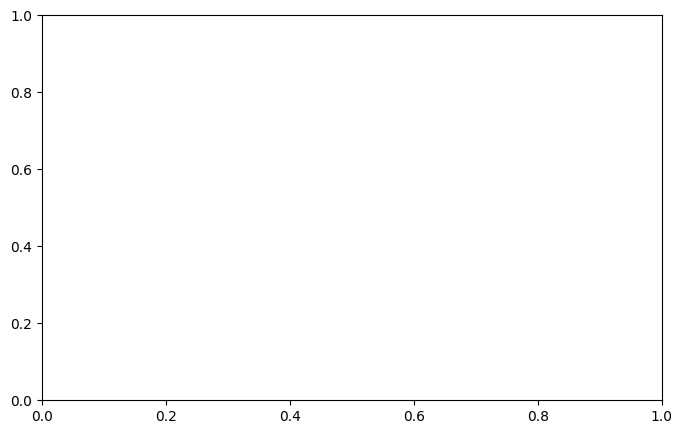

In [63]:

"""epochs = len(eval_result['test']['rmse'])
x_axis = range(0, epochs * 100, 100)  


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, eval_result['test']['rsme'], label='Test rsme', color='blue')
ax.legend()
ax.set_xlabel('Number of Boosting Rounds')
ax.set_ylabel('MAE Value')

plt.tight_layout()
plt.show()"""

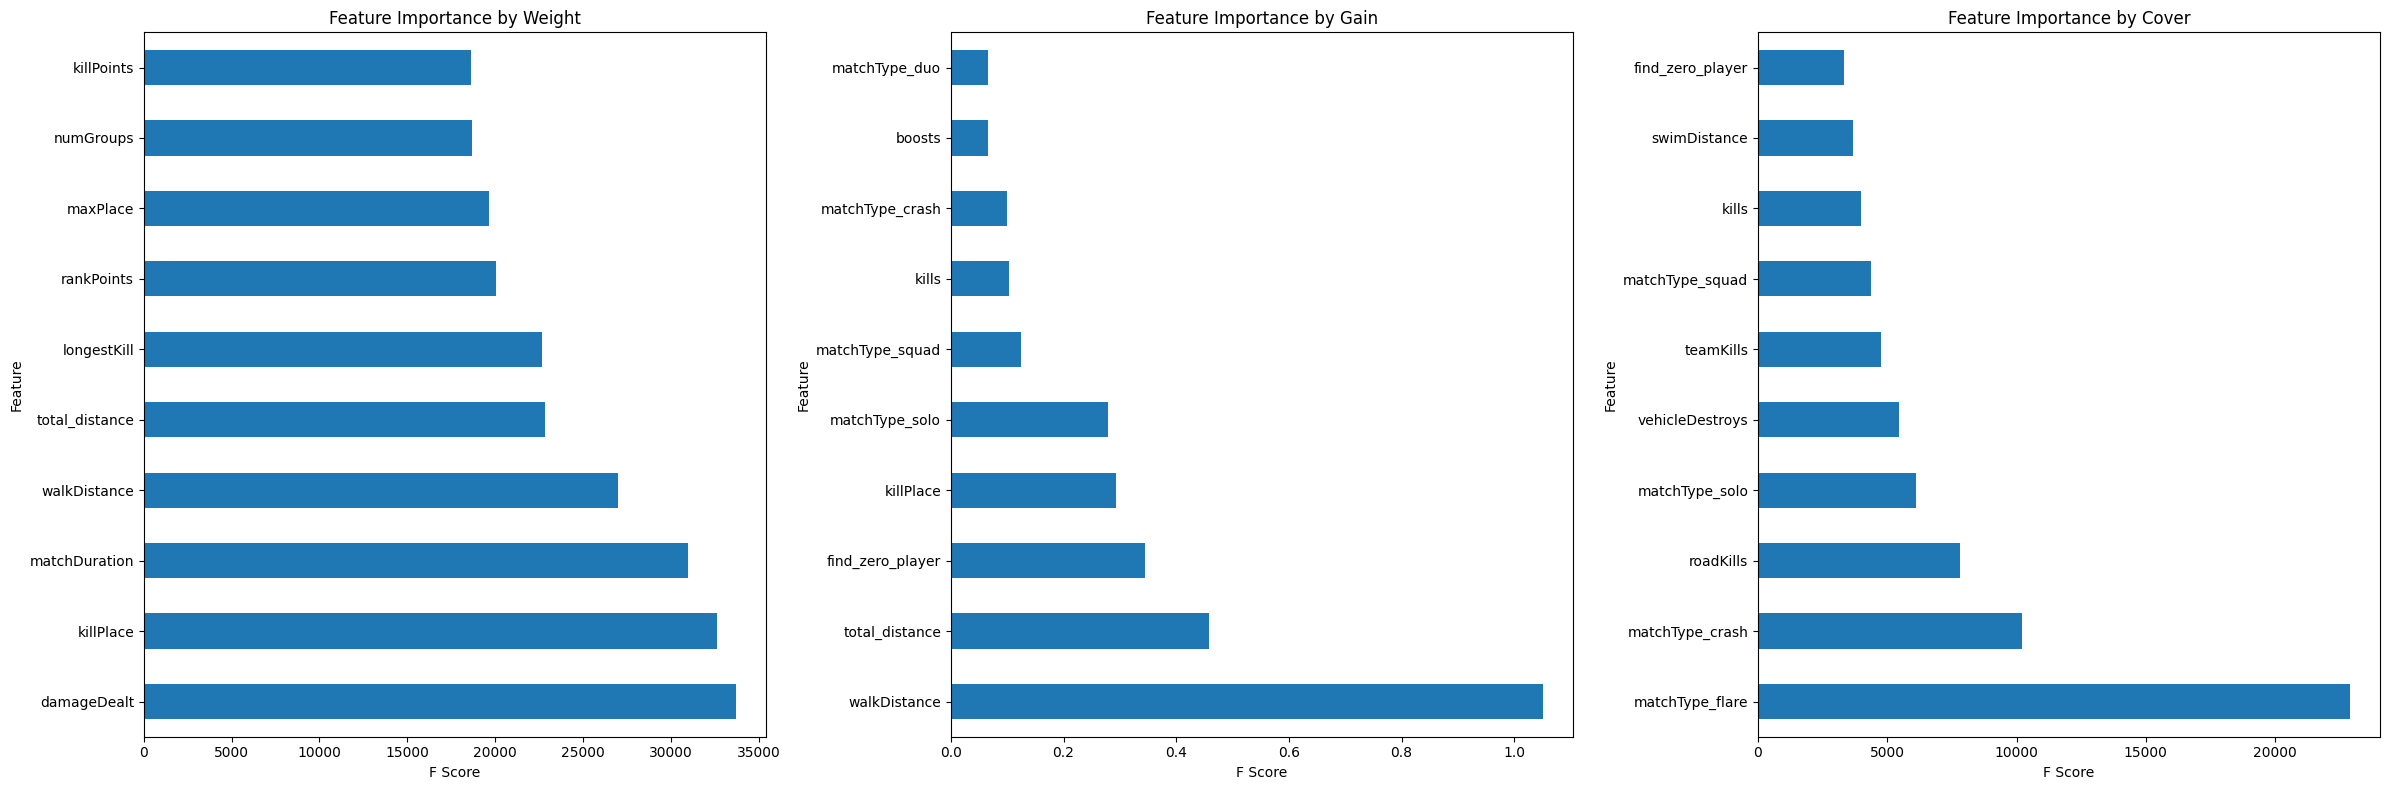

In [45]:
# 변수 중요도 계산
importance_weight = bst.get_score(importance_type='weight')
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')

# 데이터프레임 생성
df_weight = pd.DataFrame(importance_weight.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)
df_gain = pd.DataFrame(importance_gain.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)
df_cover = pd.DataFrame(importance_cover.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False)

# Top N 특성 선택
top_n = 10  # 상위 30개의 특성만 보여주기
df_weight = df_weight.head(top_n)
df_gain = df_gain.head(top_n)
df_cover = df_cover.head(top_n)

# 각 중요도 유형별로 플롯 그리기
fig, ax = plt.subplots(1, 3, figsize=(24, 8))  # 1x3 그리드, 전체 플롯 사이즈 설정

# weight
df_weight.plot.barh(x='Feature', y='Score', ax=ax[0], title='Feature Importance by Weight', legend=False)
ax[0].set_xlabel('F Score')

# gain
df_gain.plot.barh(x='Feature', y='Score', ax=ax[1], title='Feature Importance by Gain', legend=False)
ax[1].set_xlabel('F Score')

# cover
df_cover.plot.barh(x='Feature', y='Score', ax=ax[2], title='Feature Importance by Cover', legend=False)
ax[2].set_xlabel('F Score')

plt.tight_layout()  # 플롯들 사이의 공간 조절
plt.show()

In [82]:
preds = bst.predict(dtest)

ValueError: feature_names mismatch: ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'heal_boost', 'total_distance', 'find_zero_player', 'matchType_crash', 'matchType_duo', 'matchType_flare', 'matchType_solo', 'matchType_squad'] ['assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'revives', 'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired', 'matchType_crashfpp', 'matchType_crashtpp', 'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp', 'matchType_flaretpp', 'matchType_normal-duo', 'matchType_normal-duo-fpp', 'matchType_normal-solo', 'matchType_normal-solo-fpp', 'matchType_normal-squad', 'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp', 'matchType_squad', 'matchType_squad-fpp']
expected roadKills, vehicleDestroys, find_zero_player, heal_boost, maxPlace, killPoints, teamKills, matchType_crash, damageDealt, numGroups, matchType_flare, winPoints, total_distance, rankPoints in input data
training data did not have the following fields: matchType_squad-fpp, matchType_flarefpp, matchType_crashtpp, matchType_duo-fpp, matchType_normal-squad-fpp, matchType_normal-solo-fpp, matchType_crashfpp, matchType_flaretpp, matchType_normal-solo, matchType_normal-duo, matchType_normal-duo-fpp, matchType_normal-squad, matchType_solo-fpp

In [49]:
len(preds)

40000

In [52]:
sub['winPlacePerc'] = preds
sub.to_csv('submission.csv', index=False)
sub.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.209054
1,639bd0dcd7bda8,0.965735
2,63d5c8ef8dfe91,0.680624
3,cf5b81422591d1,0.582878
4,ee6a295187ba21,0.936433


In [53]:
"""epochs = np.arange(len(rmse))
plt.figure(figsize=(12, 8))
plt.plot(epochs, rmse, label='Test RMSE')
plt.plot(epochs, mae, label='Test MAE')
plt.title('RMSE and MAE Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()"""

NameError: name 'rmse' is not defined

In [ ]:
"""pred = xgb_reg.predict(test_final_df)"""


In [ ]:
"""sub['winPlacePerc'] = pred
sub.to_csv('submission.csv', index=False)
sub.head()"""